In [1]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CSQ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [3]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [4]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [6]:
df.drop(columns = ['date'], inplace = True)

In [7]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [8]:
# Explore a sample news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [9]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CSQ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [12]:
# Apply the function to the dataframe
df['combined'] = df['original'].apply(preprocess)

In [13]:
print(df['combined'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [14]:
df

,title,text,subject,isfake,original,combined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [15]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.combined:
    for j in i:
        list_of_words.append(j)


In [16]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [17]:
# join the words into a string
df['combined'] = df['combined'].apply(lambda x: " ".join(x))

In [18]:
df['combined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

In [19]:
df

,title,text,subject,isfake,original,combined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,blow million jazeera america finally calls qui...


In [20]:
# text per subject
df_grouped = df[['isfake','subject','text']].groupby(['isfake','subject']).count()
df_grouped

text
isfake subject               
0      Government News   1570
       Middle-east        778
       News              9050
       US_News            783
       left-news         4459
       politics          6841
1      politicsNews     11272
       worldnews        10145

<AxesSubplot:xlabel='count', ylabel='subject'>

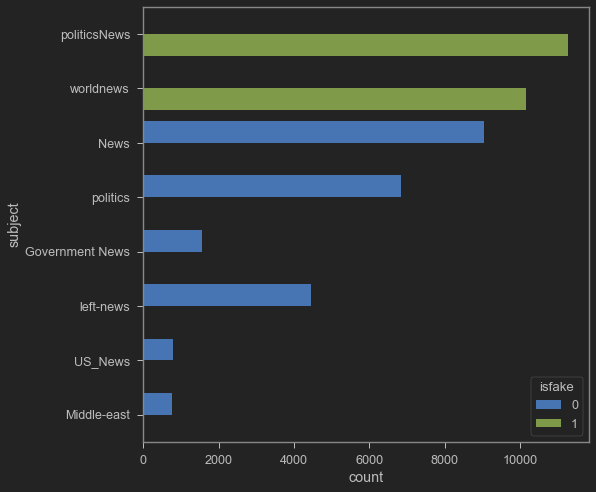

In [21]:
# plot the counts of words in subjects
plt.figure(figsize = (8,8))
sns.countplot(y = "subject", hue = "isfake", data = df)

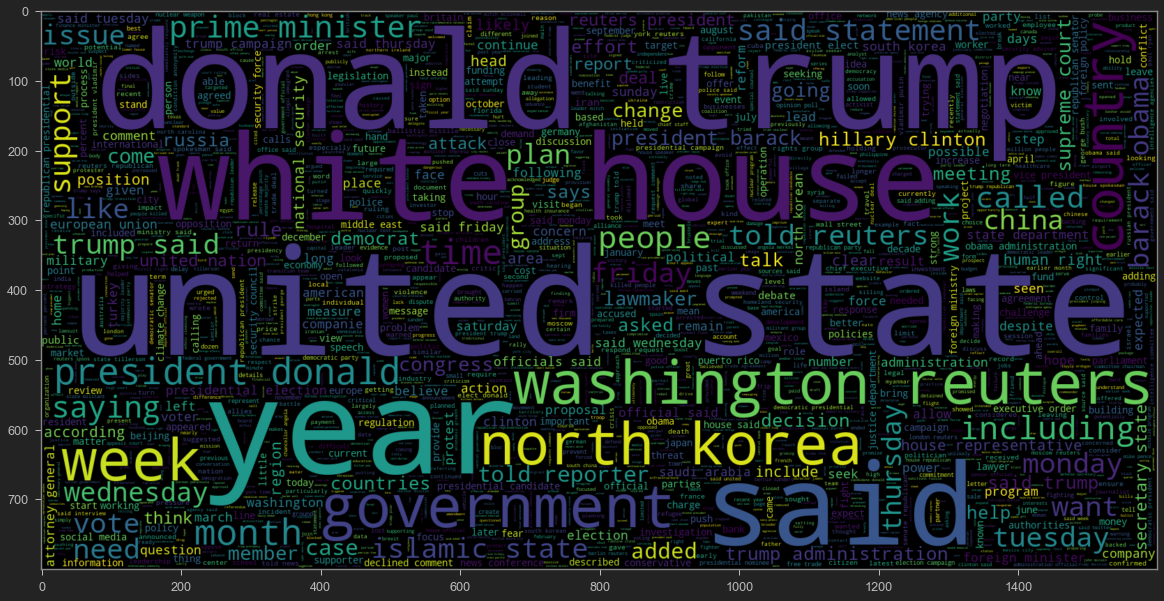

In [22]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].combined))
plt.imshow(wc, interpolation = 'bilinear')

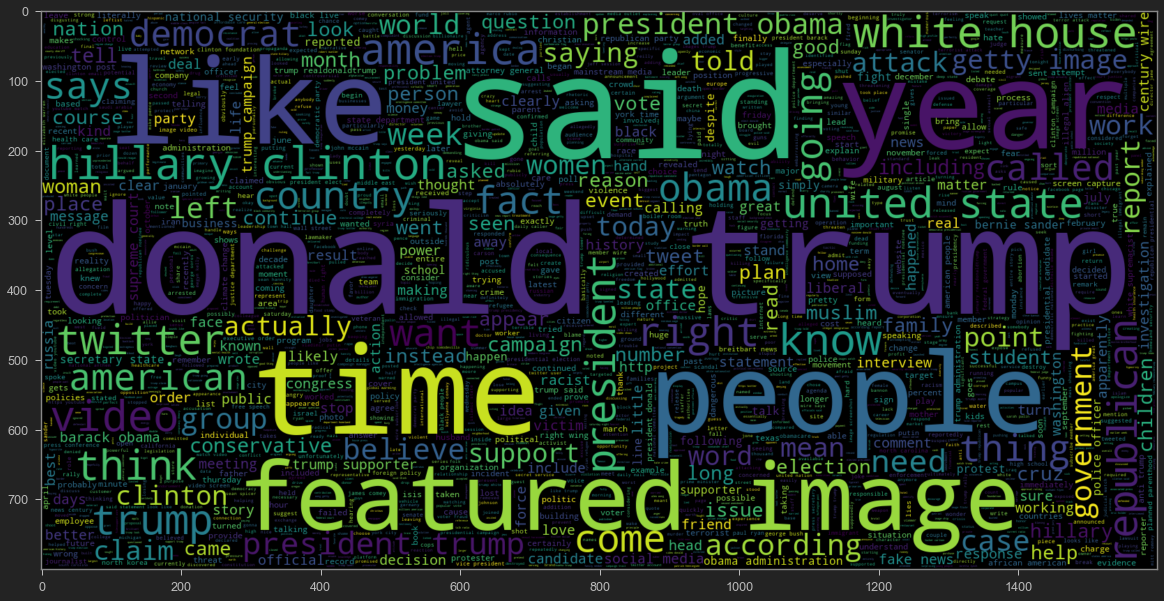

In [23]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].combined))
plt.imshow(wc, interpolation = 'bilinear')

In [24]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.combined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

The maximum number of words in any document is :  4405


In [25]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.combined, df.isfake, test_size = 0.2)

In [26]:
from nltk import word_tokenize

In [27]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [28]:
print("The encoding for document\n",df.combined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [29]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [30]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  753  1541  6275  5825   305  1835    20  5825   674  4552  2230     5
   447   128  2016  2833 26117     5  9557   329  1276   967 11346  2833
   782   110  2034   128   447   753 21855   115  2526    52  5825    20
 65173   252   106    99]
The padded encoding for document 2  is :  [6028   97 2662    1  181 2662    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [72]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim=128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(512)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         13914112  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1024)              2625536   
_________________________________________________________________
dense_23 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 16,670,977
Trainable params: 16,670,977
Non-trainable params: 0
_________________________________________________________________


In [32]:
total_words

108704

In [49]:
y_train = np.asarray(y_train)

In [73]:
# train the model
model.fit(padded_train, y_train, batch_size=64,validation_split= 0.1, epochs=2)

Epoch 1/2
506/506 [==============================] - 11s 19ms/step - loss: 0.0481 - acc: 0.9836 - val_loss: 0.0035 - val_acc: 0.9989
Epoch 2/2
506/506 [==============================] - 9s 19ms/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0042 - val_acc: 0.9992


## Deep Learning model

In [61]:
# Sequential Model
dl_model = Sequential()

# embeddidng layer
dl_model.add(Embedding(total_words, output_dim=128))

# Dense layers
dl_model.add(Dense(512, activation = 'relu'))
dl_model.add(Dense(128, activation = 'relu'))
dl_model.add(Dense(64, activation='sigmoid'))
dl_model.add(Dense(1,activation= 'sigmoid'))
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
dl_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         13914112  
_________________________________________________________________
dense_19 (Dense)             (None, None, 512)         66048     
_________________________________________________________________
dense_20 (Dense)             (None, None, 128)         65664     
_________________________________________________________________
dense_21 (Dense)             (None, None, 64)          8256      
_________________________________________________________________
dense_22 (Dense)             (None, None, 1)           65        
Total params: 14,054,145
Trainable params: 14,054,145
Non-trainable params: 0
_________________________________________________________________


## Predict the by Deep Learning models

#### Deep Learning Model Prediction

In [62]:
dl_model.fit(padded_train, y_train, batch_size=64,validation_split= 0.1, epochs=4)

Epoch 1/4
506/506 [==============================] - 5s 9ms/step - loss: 0.5555 - acc: 0.7068 - val_loss: 0.5370 - val_acc: 0.7173
Epoch 2/4
506/506 [==============================] - 4s 9ms/step - loss: 0.5206 - acc: 0.7339 - val_loss: 0.5409 - val_acc: 0.7206
Epoch 3/4
506/506 [==============================] - 4s 9ms/step - loss: 0.5134 - acc: 0.7364 - val_loss: 0.5365 - val_acc: 0.7204
Epoch 4/4
506/506 [==============================] - 5s 9ms/step - loss: 0.5105 - acc: 0.7373 - val_loss: 0.5374 - val_acc: 0.7228


#### Bidirectional LSTM

In [69]:
# make prediction
pred = model.predict(padded_test)

In [36]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [58]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test),prediction)

print("Bidirectional LSTM Model Accuracy : ", accuracy)

Bidirectional LSTM Model Accuracy :  0.9984409799554566


<AxesSubplot:>

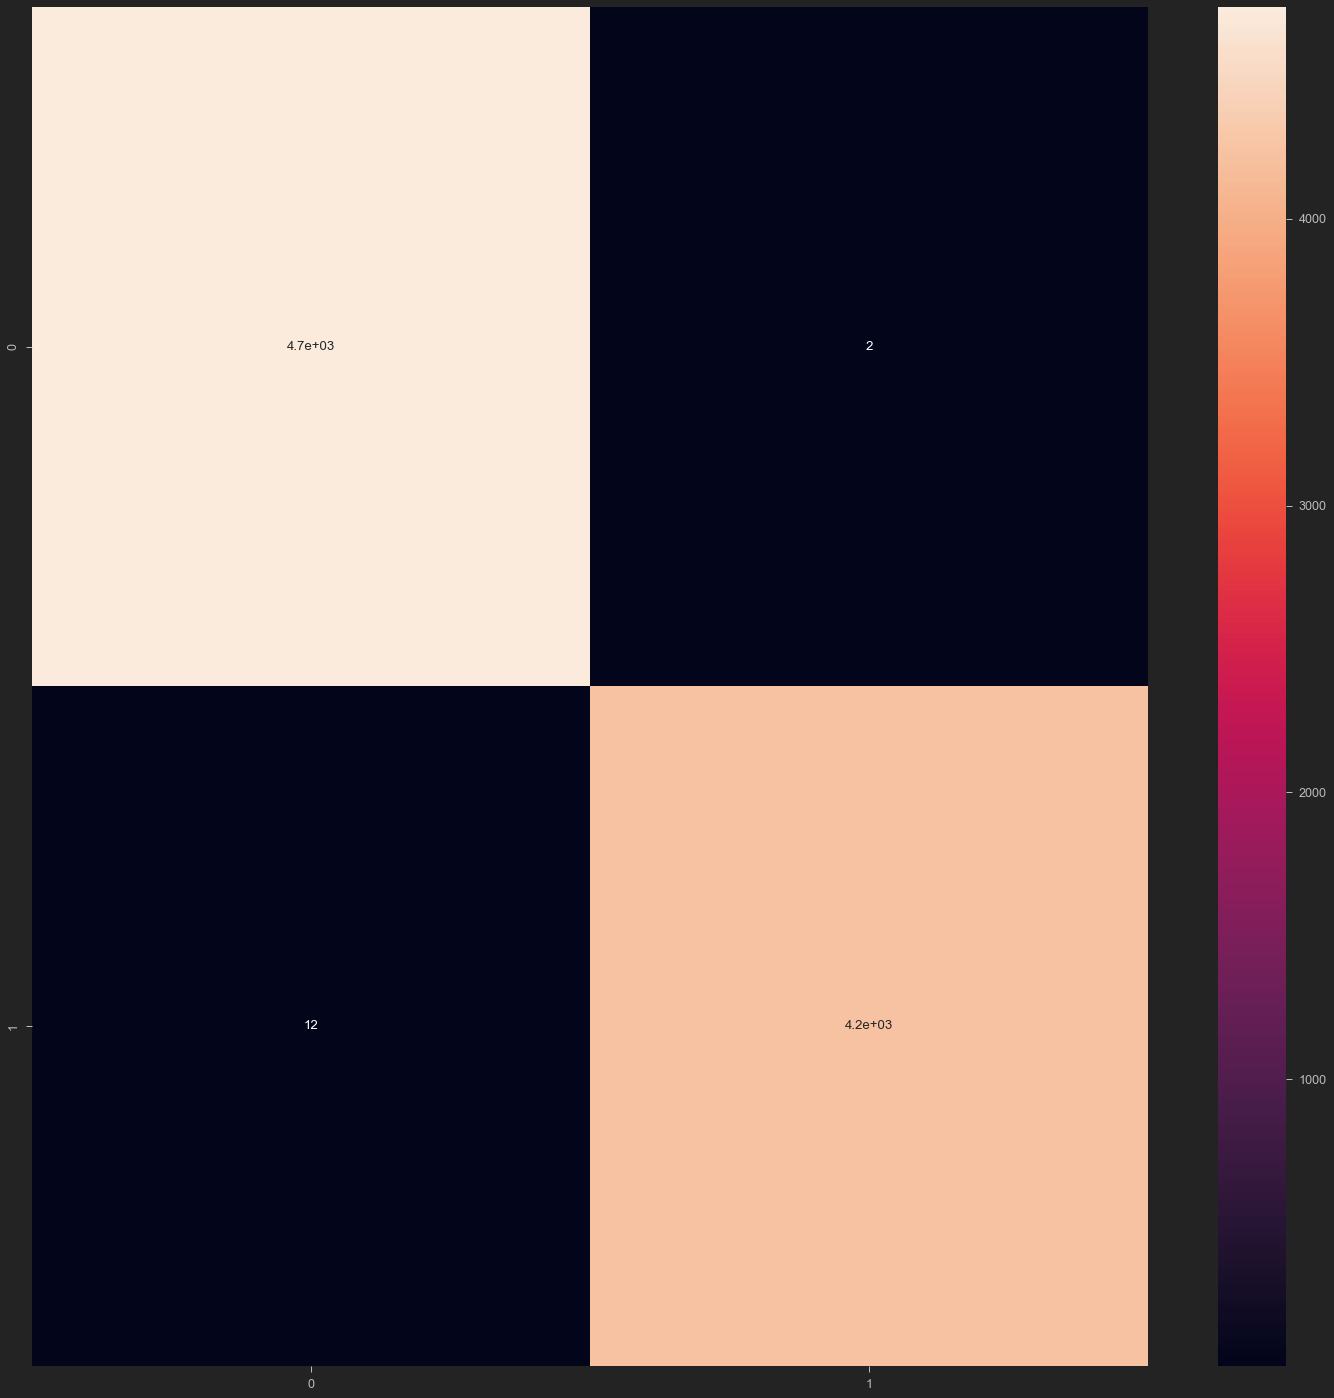

In [38]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)


### FLAML

* XGBOOST
* LGBM
* Random Forest

In [39]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

In [46]:
from flaml import AutoML
automl = AutoML()
automl_settings = {
    "time_budget": 240,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "california.log",
}
automl.fit(X_train=padded_train, y_train=y_train,**automl_settings)

[flaml.automl: 04-05 19:26:56] {2068} INFO - task = regression
[flaml.automl: 04-05 19:26:56] {2070} INFO - Data split method: uniform
[flaml.automl: 04-05 19:26:56] {2074} INFO - Evaluation method: holdout
[flaml.automl: 04-05 19:26:56] {2155} INFO - Minimizing error metric: 1-r2
[flaml.automl: 04-05 19:26:56] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 04-05 19:26:56] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 04-05 19:26:56] {2617} INFO - Estimated sufficient time budget=625s. Estimated necessary time budget=4s.
[flaml.automl: 04-05 19:26:56] {2669} INFO -  at 0.1s,	estimator lgbm's best error=0.8265,	best estimator lgbm's best error=0.8265
[flaml.automl: 04-05 19:26:56] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 04-05 19:26:56] {2669} INFO -  at 0.1s,	estimator lgbm's best error=0.8265,	best estimator lgbm's best error=0.8265
[flaml.automl: 04-05 19:26:56] {2501} IN

In [47]:
print(automl.model.estimator)

LGBMRegressor(colsample_bytree=0.7165598320183149,
              learning_rate=0.025251935531525466, max_bin=1023,
              min_child_samples=11, n_estimators=32325, num_leaves=22,
              reg_alpha=0.008110414105028607, reg_lambda=0.010581187305414307,
              verbose=-1)
